### Predicting survival on Titanic Kaggle's dataset and getting familiar with ML basics

In [3]:
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

    Let's check how many entries are missing in the dataset (null values) 

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


    Also, let's define a function to plot the missing data:

In [6]:
def plot_missing_data(dataset, title):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(title)
    sns.heatmap(dataset.isnull(), cbar=True)

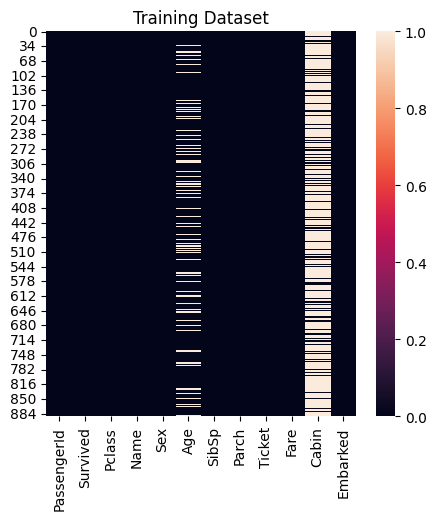

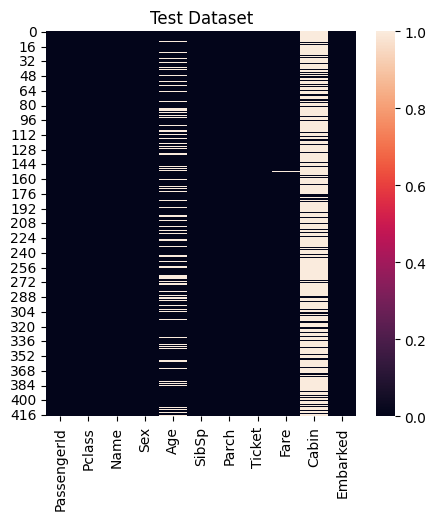

In [7]:
plot_missing_data(train_df, "Training Dataset")
plot_missing_data(test_df, "Test Dataset")

#### Question 1: How many passengers survived? Reminder: "0" = No, "1" = Yes

In [8]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

    The resulting object will be in descending order so that the first element is the most frequently-occurring element. Normalizing will return the % (frequency of occurrence) for this event

In [9]:
train_df['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

    We can also define a function to plot a bar chart:

In [10]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived', 'Passengers Died']
    ax = df_survived_dead.plot(kind='bar', stacked=stacked, figsize=(5,5))

In [ ]:
import pandas as pd

def bar_chart_stacked(dataset, feature, stacked=True):
    # Filtrar os clientes que aproveitaram ou não a oferta
    clientes_aproveitaram = dataset[dataset['Aproveitou Oferta?'] == True][feature].value_counts()
    clientes_nao_aproveitaram = dataset[dataset['Aproveitou Oferta?'] == False][feature].value_counts()
    
    # Criar um DataFrame com as contagens
    df_aproveitamento_oferta = pd.DataFrame({'Clientes Que Aproveitaram': clientes_aproveitaram,
                                             'Clientes Que Não Aproveitaram': clientes_nao_aproveitaram})
    
    # Plotar o gráfico de barras
    ax = df_aproveitamento_oferta.plot(kind='bar', stacked=stacked, figsize=(5, 5))

# Exemplo de uso da função com o DataFrame "dados_clientes" e a característica "Idade"
bar_chart_stacked(dados_clientes, "Idade")


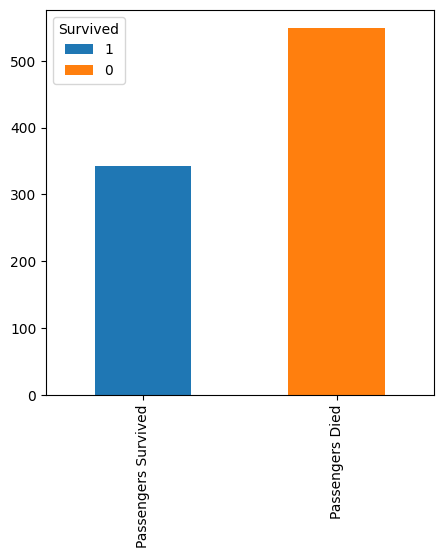

In [11]:
bar_chart_stacked(train_df, "Survived")

    I like the function above because we can filter a certain result in the dataframe and check what is the value for a specific column (feature) in the same df

#### Question 2: Is the likelihood of survival dependent on gender?

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
survival rate female/male = 3.928037164728569


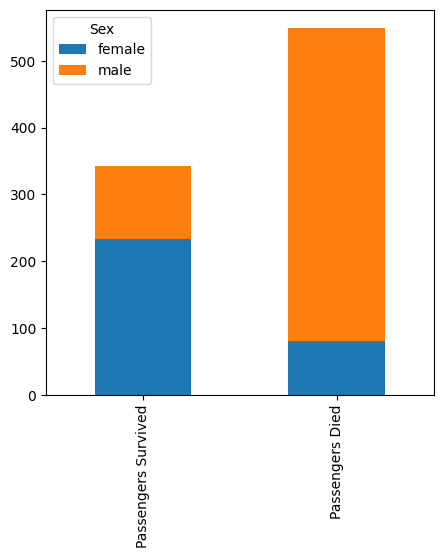

In [12]:
train_df['Sex'].value_counts().to_frame()
print(train_df.groupby('Sex')["Survived"].mean()) # or print(train_df.groupby('Sex').Survived.mean())
survival_mean = train_df.groupby('Sex')["Survived"].mean()
female_survival_mean = survival_mean[0]
male_survival_mean = survival_mean[1]
bar_chart_stacked(train_df, "Sex")
print("survival rate female/male = " + str(female_survival_mean/male_survival_mean))

    Survival rate for woman are 4x higher than the survival rate of male passengers

#### Question 3: Could it be that the class to which a passenger belonged correlates with the probability of survival?

In [13]:
df_pivoted = pd.pivot_table(train_df, index='Survived', columns='Pclass', values='Ticket', aggfunc='count')
df_class_mean = train_df.groupby(['Pclass'])["Survived"].mean().to_frame() # or train_df.groupby(['Pclass']).Survived.mean().to_frame()

    We clearly can see that there is a higher survival rate for higher class. So that's an important factor to consider

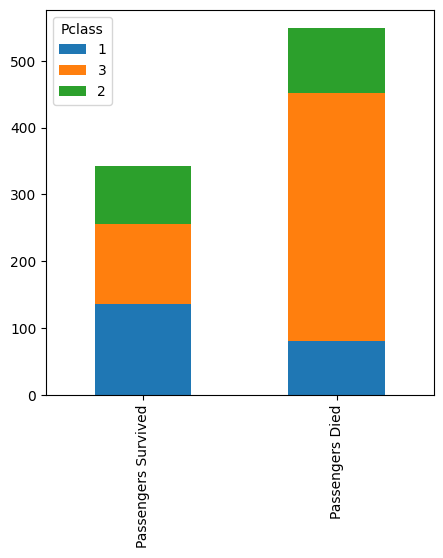

In [14]:
bar_chart_stacked(train_df, 'Pclass')

    Key Observations:
    
    - Most passengers had class 3 tickets, yet only 24% of class 3 passengers survived
    - Almost 63% of the passenger from class 1 survived
    - Approx. 50% of the class 2 passengers survived
    
    However, it's not clear yet weather the class or the gender is the underlying and deciding factor. Which brings another important question.

#### Question 4: Is the higher survival rate in Class 1 due to the class itself or due to a skewed gender distribution in which female passengers dominate?

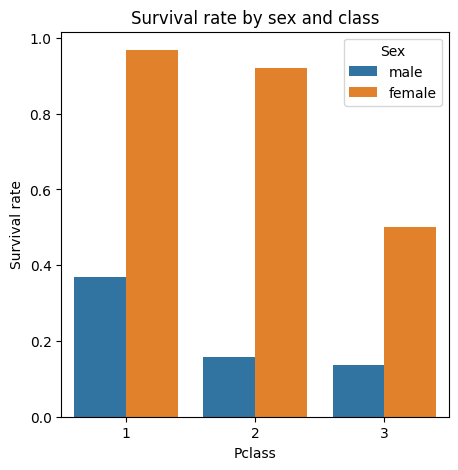

In [15]:
def bar_chart_compare(dataset, feature1, feature2 = None):
    plt.figure(figsize=[5,5])
    plt.title('Survival rate by sex and class')
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, errorbar=None, data=dataset).set_ylabel('Survival rate')

bar_chart_compare(train_df, "Pclass", "Sex")

    Note: 'hue' is used to add a second layer of grouping. In the example above, it plot both bar graphs for the same information but changing 'sex'a

    The bar plot above is doing the follow operation and plotting it:

In [16]:
train_df.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

    From results above, we can see that irrespective of the class the most important factor when it comes to survival was gender (at least between the two features Sex and Pclass). However, men had a significantly higher change of survival if they bought class 1 tickets. This just shows that we should keep both features as both yield insightful information that should help our model

    Key observations:

        - Survival Rate females 1. Class: 96.8%
        - Survival Rate females 2. Class: 92.1%
        - Survival Rate females 3. Class: 50%
        
        - Survival Rate Male 1. Class: 36.8% (still significantly lower than 3. class females)

### Question 5: Did a passengers age influence the chance of survival?

    Function to plot a histogram:

In [17]:
def plot_distribution(dataset, feature, title, bins = 30, hist=True, fsize=(5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)

    Function to plot the kernel density estimate:

In [18]:
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize=(5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"]==1],
                fill=True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"]==0],
                fill=True, ax=ax, label='Died')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_4600\3926994053.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)


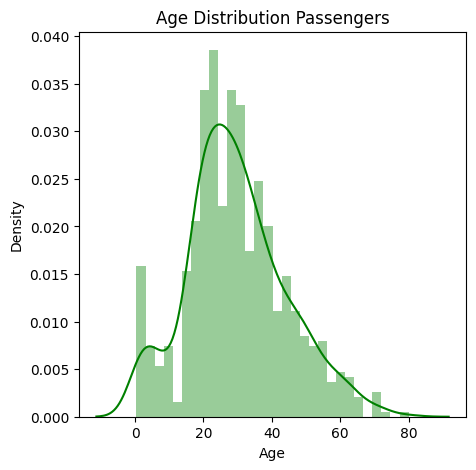

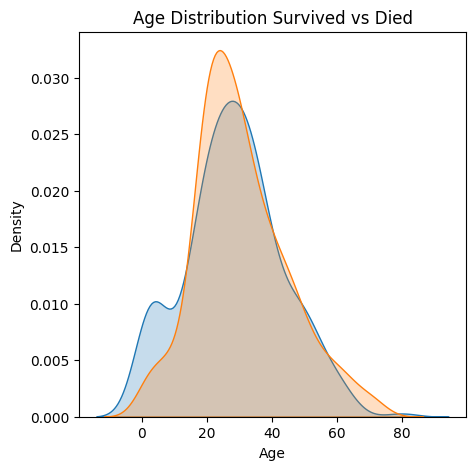

In [19]:
plot_distribution(train_df, "Age", "Age Distribution Passengers")

plot_kernel_density_estimate_survivors(train_df, "Age", "Age Distribution Survived vs Died")

# Encontrar alternativa para corrigir problema do 'distplot' usando chatGPT

    As we can see, age follows a fairly normal distribution. From the density plot, we can see a raise in survivors at a very young age

    One idea might be to investigate age and sex together using a swarm plot, as it does not seem plausible that age has no influence on the chance of survival:

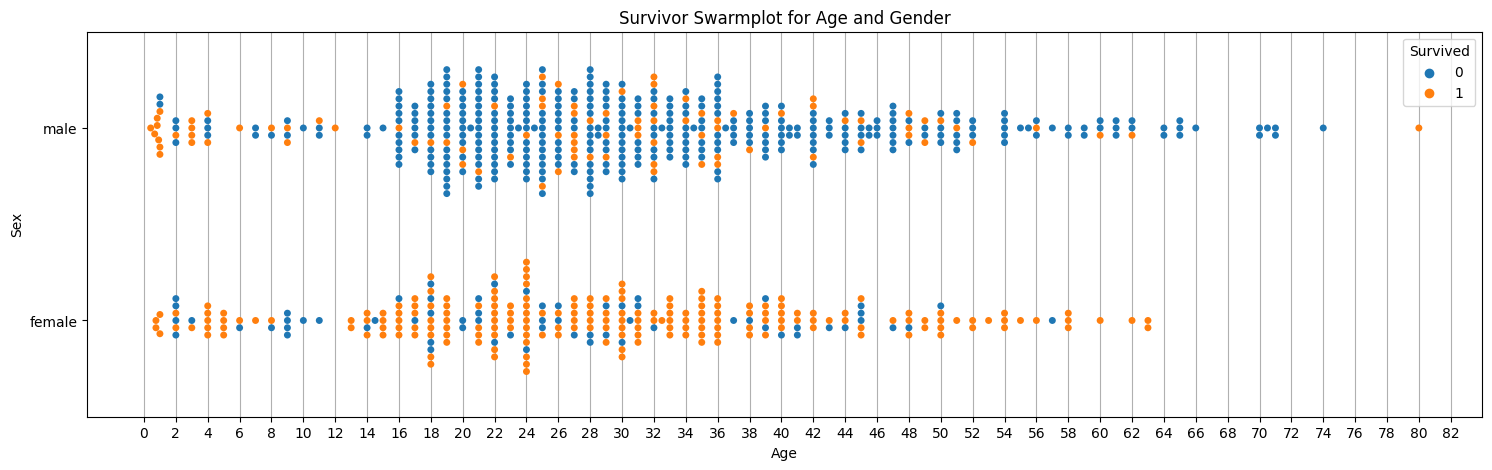

In [20]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fsize= (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived', data=train_df).set_title(title)
    
plot_swarm_survivors(train_df, "Sex", "Age", "Survivor Swarmplot for Age and Gender")

    The plot above shows that a big portion of male survivors are passengers between 0 and 12 years of age. Also, the oldiest male passengers at age 80 survived

    We can also check from the plot below how important the Pclass is when it  comes to predicting the likelihood of survival. The first-class did not have a lot of children (maybe rich people get fewer kids in general?)

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 55.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 76.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


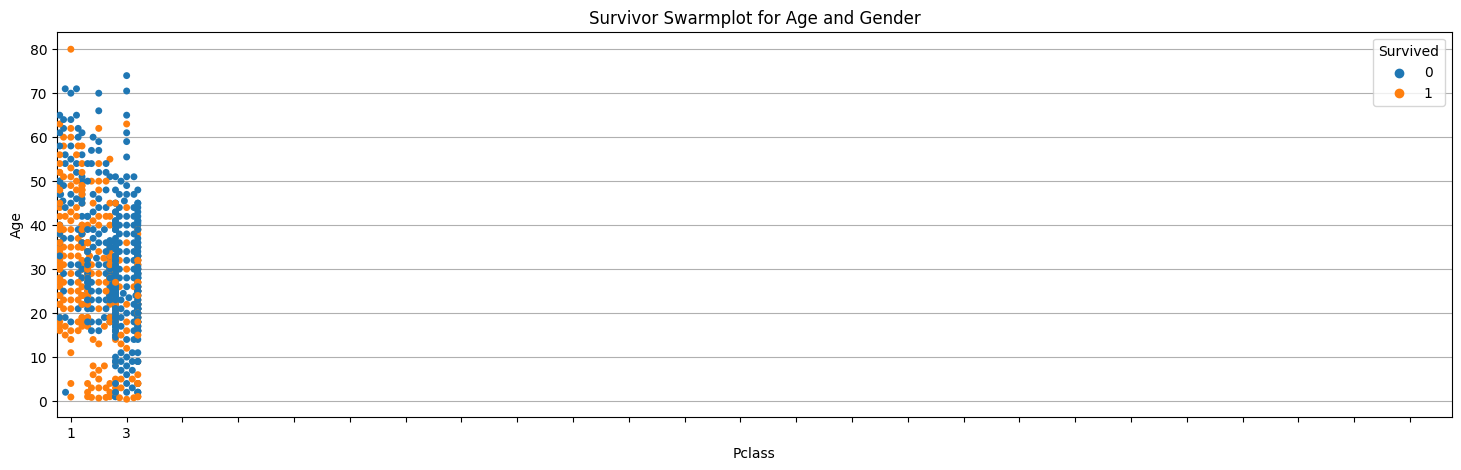

In [21]:
plot_swarm_survivors(train_df, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")

#### Question 6: Did paying the ticket price influence the chance of survival?

    Get info about the Fare column values in our train_df

In [22]:
print(train_df.Fare.describe())

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


C:\Users\Daniel\AppData\Local\Temp\ipykernel_4600\3926994053.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)


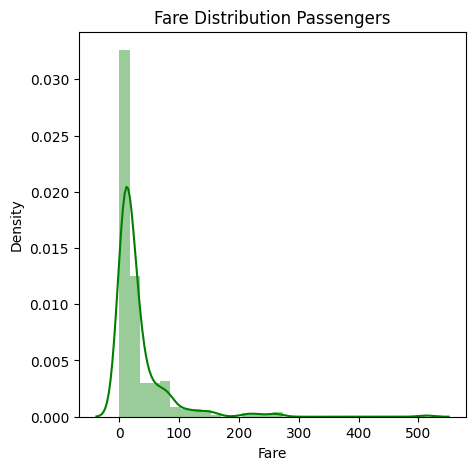

In [23]:
plot_distribution(train_df, "Fare", "Fare Distribution Passengers")

    Fare does not follow a normal distribution and has a huge spike at the price range [0–100$].

    To better understand how this feature influences the survival rate, we could plot bar plots of Fare vs Survived. Due to the large range of fares such as plot would not be useful for inferring useful information. A better suited visualization would be to combine fares into categories and then plot the categories vs Survived.

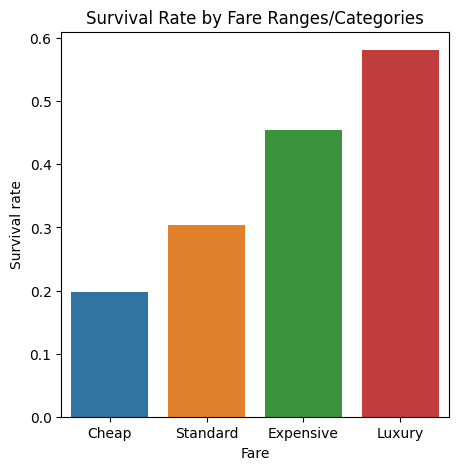

In [24]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels=categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, errorbar=None, ax=axarr).set_ylabel('Survival rate')

categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']
plot_quartiles(train_df, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

    As we can see the likelihood of survival is definitely influenced by the price paid.

    '''
    Key Observations:

    - Cheap (0-25% of max Price): Surival Rate = 0.2 (approx)
    - Standard (25%-50% of max Price): Surival Rate = 0.3 (approx)
    - Expensive (50%-75% of max Price): Surival Rate = 0.45 (approx)
    - Luxury (75%-100% of max Price): Surival Rate = 0.55 (approx)

    Additionally, we can investigate the relationship between fare, sex and survived to further understand the importance of the feature:

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 91.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 83.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


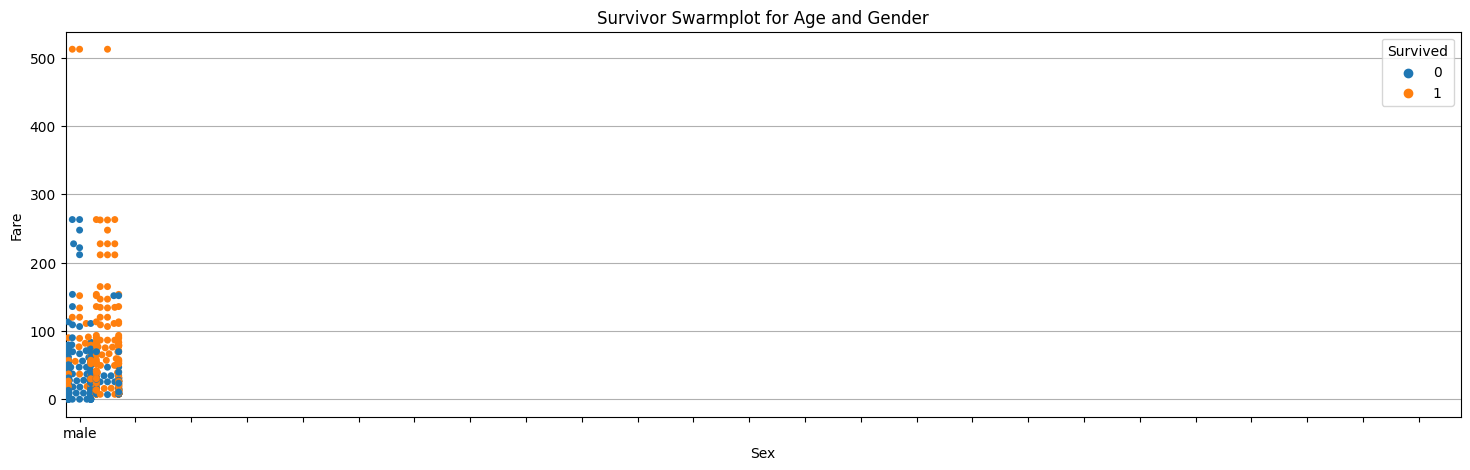

In [25]:
plot_swarm_survivors(train_df, "Fare", "Sex", "Survivor Swarmplot for Age and Gender")

    Key observations:

    - Irrespective of gender all passengers with a fare above 500$ survived.
    - All male passenger that paid between 200-300$ died
    - All female passenger that paid between 200-300$ survived

    This could potentially be a pattern a classifier might pick up

    Another point: Since a free ride on the Titanic makes no sense, let's replace the values for the ticket price with NAN's for these passengers. Below we can see the passengers with fare = 0:

In [26]:
train_df.loc[train_df.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


    We could argue that these passengers in fact didn't pay the fare due to a particular position they held (Reporters, family members of the crew etc)
    
    We will discuss the handling of this feature separately in the Feature Engineering part

    # Replacing Fare == 0 with NaN:

#### Question 8: Could the place of embarkation influence the chance of survival?

    Intuition would not make me believe that the place of embarkation matters at all, however, we must dedicate ourselves to not make assumptions about that data
        
    One approach to analyze this is to use count plots for the 3 different locations of embarkation Southcampton, Cherbourg and Queenstown:

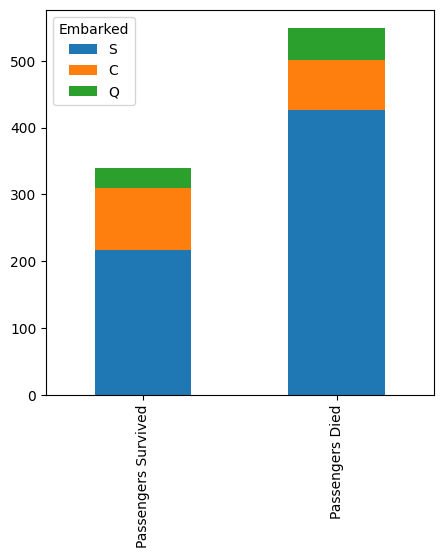

In [27]:
def show_countplot(dataset, feature, title, fsize=(5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)

def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x= feature1, hue= feature2, data = dataset, ax=ax).set_title(title)

bar_chart_stacked(train_df, 'Embarked')

In [28]:
# show_countplot(train_df, 'Embarked', 'Passengers count by boarding point') -- náo funcionou, erro:could not convert string to float: 'S' 

In [29]:
train_df['Embarked'].value_counts().to_frame()

,count
Embarked,
S,644
C,168
Q,77


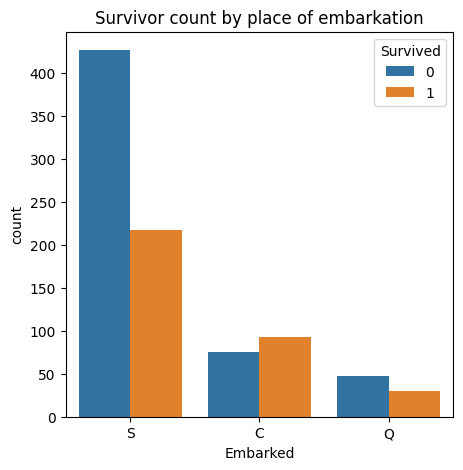

In [30]:
show_compare_countplot(train_df, "Embarked", "Survived", "Survivor count by place of embarkation")

In [31]:
pd.pivot_table(train_df, index='Survived', columns='Embarked', values='Ticket', aggfunc='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


    We can see that the majority of passengers embarked from Southampton. However, only 33% survived the sinking of the titanic. The highest survival rate of 55% is in the group of passengers that embarked from Cherbourg.

    While it is important to look at the data without making prior assumptions common sense should be used at all times. Why should the place of embarkation influence the survival rate at all? Why is the likelihood of survival higher at Cherbourg?

#### Question 9: Was the high number of survivors that embarked at Cherbourg due to a high number of 1.Class passengers?
    Let's check this point and see how many 1.Class passengers embarked at Cherbourg

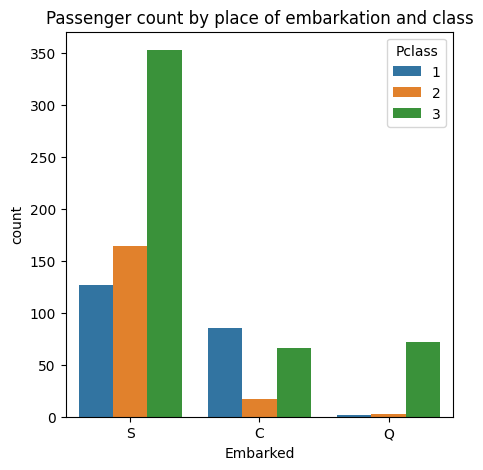

In [32]:
show_compare_countplot(train_df, "Embarked", "Pclass", 'Passenger count by place of embarkation and class')

    Count for number of survivors with respect to place of embarkation and class:

In [33]:
train_df.groupby([ 'Embarked', 'Pclass']).Survived.sum().to_frame()

Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67

In [34]:
train_df.groupby([ 'Embarked', 'Pclass']).Survived.count().to_frame() # to check total number of passengers in each class for each region

Survived
Embarked Pclass          
C        1             85
         2             17
         3             66
Q        1              2
         2              3
         3             72
S        1            127
         2            164
         3            353

    The hypothesis seems to be correct
    - The majority embarked at Cherboug were 1.Class passengers
    - The majority embarked at Southampton were 3.CLass passengers
    However, it does not explain why the survival rate for Queenstown passeners is slighlt higher than at Southampton even though the number of 1.Class passengers in relation to 3.Class passengers is higher for Southampton

    One explanation might be that the ratio between male and famale passengers differs

#### Question 10: Is gender distribution responsible for the slightly higher passenger survival rate in Queenstown compared to Southampton?

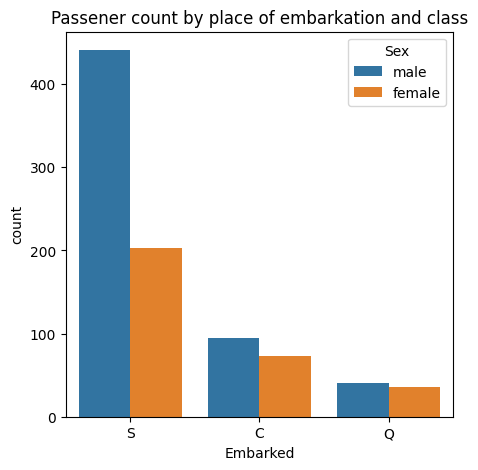

In [35]:
show_compare_countplot(train_df, "Embarked", "Sex", "Passener count by place of embarkation and class")

    The plot confirms that twice as much male passengers embarked from Southamp and roughly the same number of male and female passengers embarked from Queenstown. This just shows the importance of the Sex feature.

#### Question 11: Does the number of children/siblings/spouses or parents on board influence the chance of survival?

    SibSp (number of siblings/spouses aboard the Titanic):

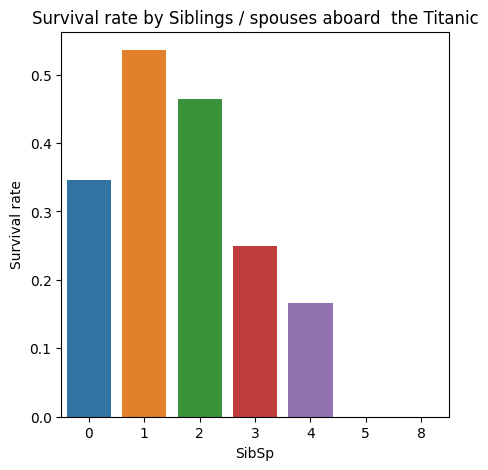

In [36]:
plt.figure(figsize=[5,5])
plt.title('Survival rate by Siblings / spouses aboard  the Titanic')
g = sns.barplot(data = train_df, x='SibSp', y='Survived', hue=None, errorbar=None).set_ylabel('Survival rate')

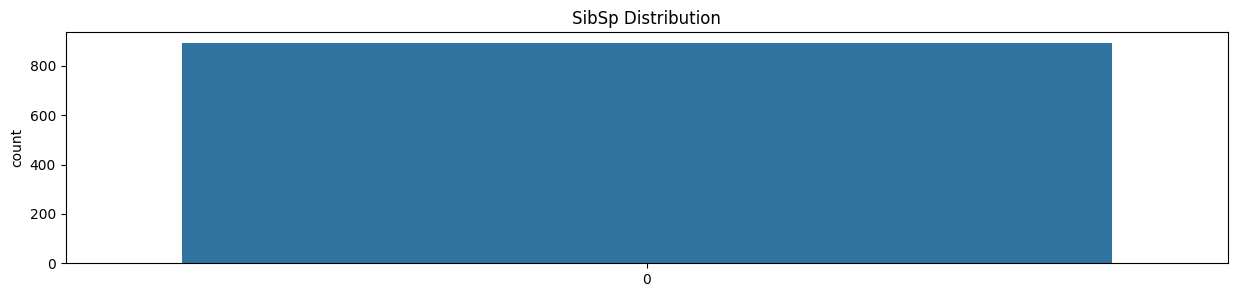

In [37]:
show_countplot(train_df, 'SibSp', 'SibSp Distribution', fsize=(15,3)) # didn't work as the tutorial

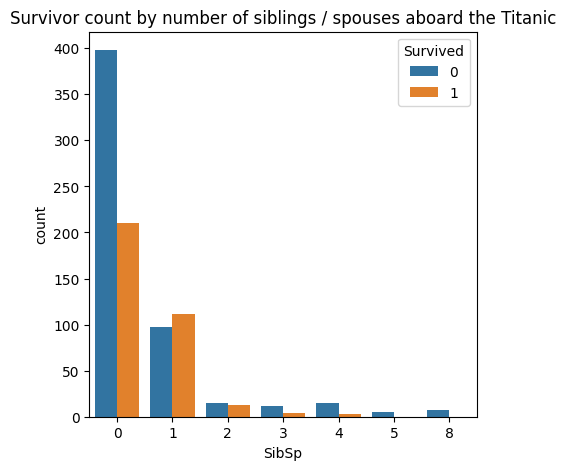

In [38]:
show_compare_countplot(train_df, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")

    As we can see from the plots above, the majority of passengers traveled alone. It seems that, the more siblings a passenger has the less chance of survival there is.

    Let's check the results for Parch (number of parents / children aboard the Titanic): 

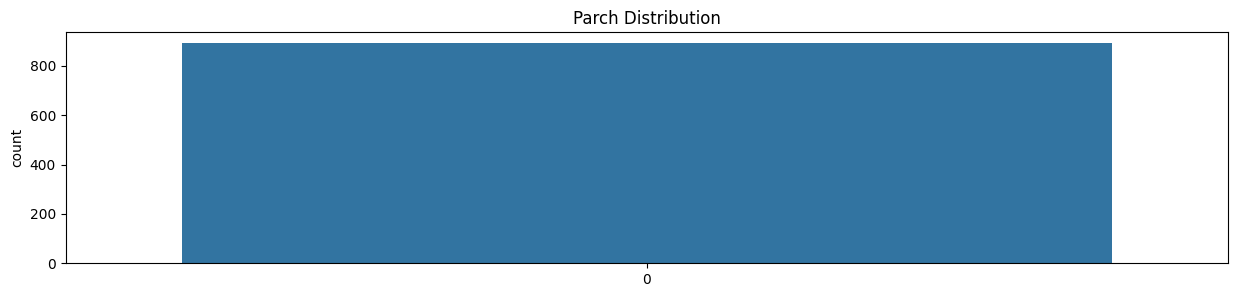

In [39]:
show_countplot(train_df, "Parch", 'Parch Distribution', (15,3)) # results looking weird as well

    Similar to the SibSp column, this feature contains the number of parents or children each passenger was traveling with.

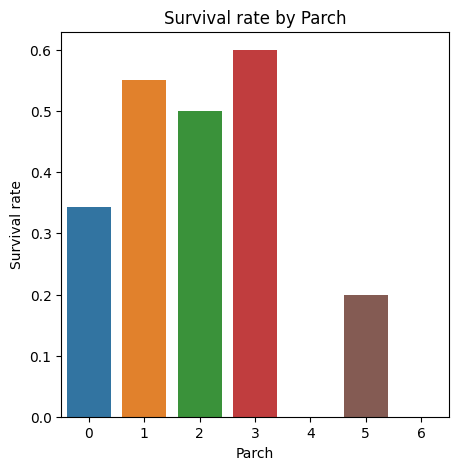

In [40]:
plt.figure(figsize=[5,5])
plt.title('Survival rate by Parch')
g = sns.barplot(data = train_df, x='Parch', y='Survived', hue=None, errorbar=None).set_ylabel('Survival rate')

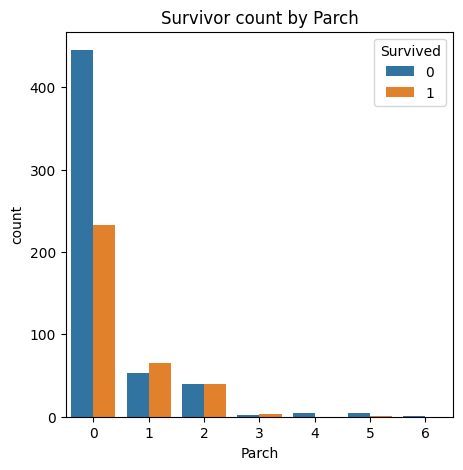

In [41]:
show_compare_countplot(train_df, "Parch", "Survived", "Survivor count by Parch")

    Here we draw the same conclusions as for Parch as for SibSp. We can see against that small families had more chances to survive than bigger ones and apssengers who traveled alone. 

    Later in the feature engineering part we will think about how to combine Parch and SibSp to a new feature that utilizes the information of both features

## 3. Feature Engineering
### 3.1 Feature Name:

    One feature that we did not consider until now is the name. In theory, a person’s name should have no influence on the probability of survival, but on closer investigation we see that a title is sometimes hidden in the name, which in turn could be quite useful. However, using the different names as categorical variables does not make sense. One idea is to extract the title from the name.

In [42]:
pd.unique(train_df['Name'])

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

    Code to extract title from name:

In [43]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

train_df # to check the new added column

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


    If we look now at the count plot of the new title feature, we wee that certain titles dominate:

In [44]:
train_df['Title'] = train_df['Title'].astype(str)

Text(0.5, 1.0, 'Title Distribution')

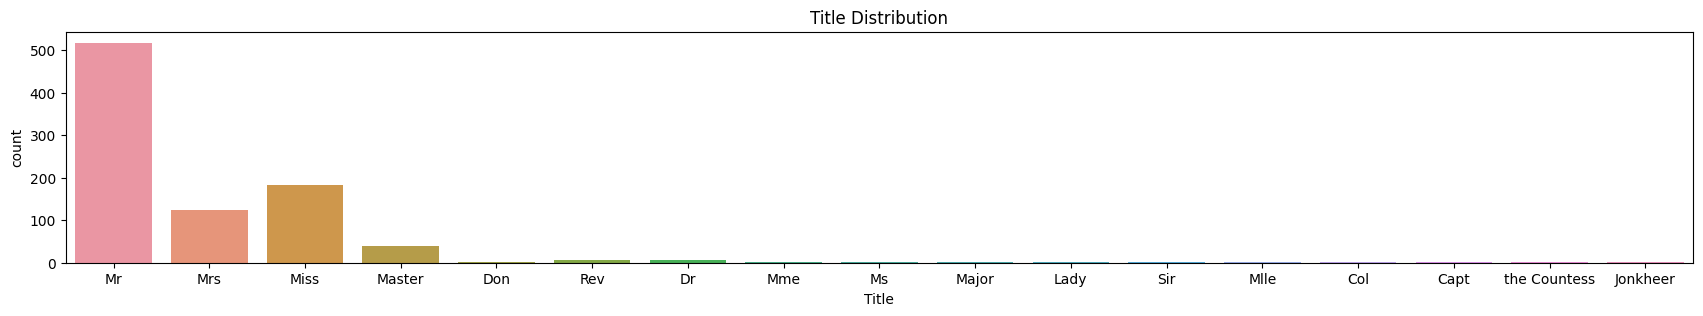

In [45]:
fig, ax = plt.subplots(figsize=(21,3))
sns.countplot(x='Title', data = train_df, ax=ax).set_title('Title Distribution')

    In this case it makes sense to group less frequent Titles together. I will substitute male titles into Mr and female Titles into Mrs (ask chatGPT how to):

In [46]:
# create a dictionary to map titles to 'Mr' or 'Mrs'
title_map = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Mrs', 'Master': 'Master', 'Don': 'Mr', 'Rev': 'Rev', 'Dr': 'Dr', 'Mme': 'Mrs', 'Ms': 'Mrs', 'Major': 'Mr', 'Lady': 'Mrs', 
             'Sir': 'Mr', 'Mlle': 'Mrs', 'Col': 'Mr', 'Capt': 'Mr', 'the Countess': 'Mrs', 'Jonkheer': 'Mr'}

# replace the titles with 'Mr' or 'Mrs'
train_df['Title'] = train_df['Title'].replace(title_map)

# print the updated dataframe
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mrs
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Mrs
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mrs
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


    Let's investigate the title feature and the survival rate together


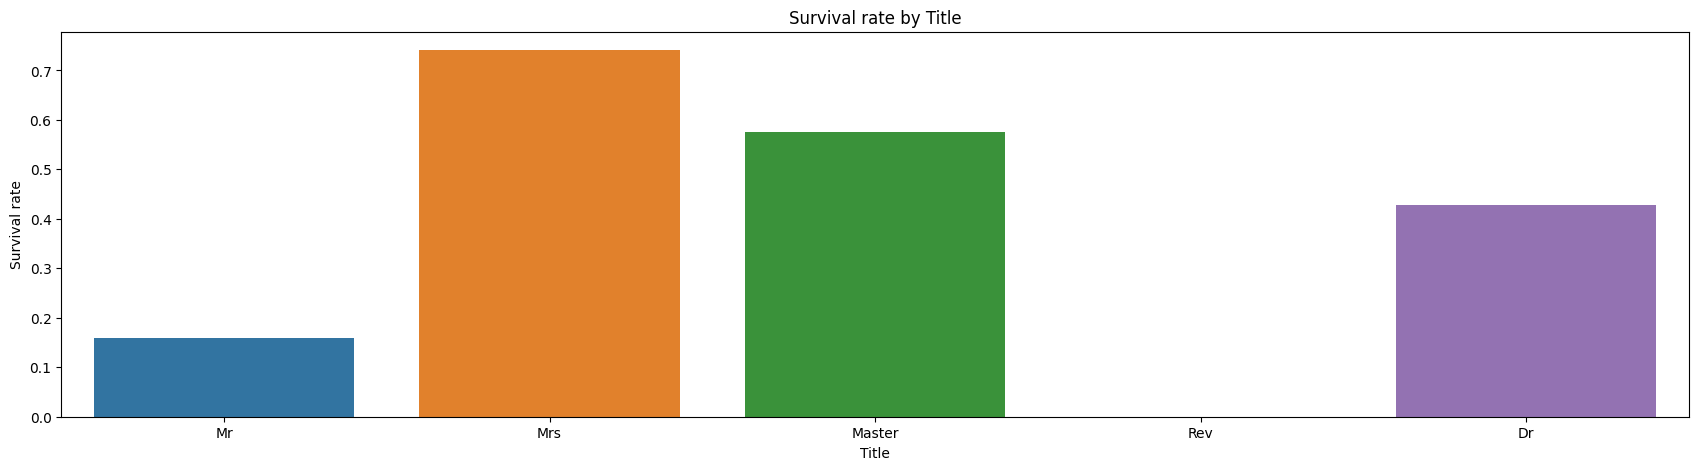

In [47]:
# bar_chart_compare(train_df, "Title").set_title("Survival rate by Title")

plt.figure(figsize=[21,5])
plt.title('Survival rate by Title')
g = sns.barplot(x='Title', y='Survived',errorbar=None, data=train_df).set_ylabel('Survival rate')

    Key observations:

    Female titles result in a higher survival rate.
    Master and Dr have a surprisingly high survival rate even tough both are male titles.
    Being “just” a Mr results in a bad survival rate of approx 15%
    All 6 revenants died. Maybe they decided to accept their destiny and wanted to die with dignity.

### 3.2 Feature Cabin and Ticket:

In [48]:
train_df[['Cabin' , 'Ticket']]

,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,B42,112053
888,NaN,W./C. 6607
889,C148,111369


    As we can see both features are not easy to deal with. Cabin contains a lot of NaN’s and the ticket seems not to provide any useful information.

    We can try different ideas:

    Extract two leading letters to create a new feature
    Extract number of letter in ticket to create a new features
    Extract number of cabins used
    Extract Cabin letter

    Extract Leading Letter:

In [49]:
train_df['Ticket_2letter'] = train_df.Ticket.apply(lambda x: x[:2]) #ask chatGPT to explain this line
test_df['Ticket_2letter'] = test_df.Ticket.apply(lambda x: x[:2])

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mrs,ST
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Mrs,11
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mrs,W.
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,11


    Extract Ticket Length:

In [50]:
train_df['Ticket_len'] = train_df.Ticket.apply(lambda x: len(x))
test_df['Ticket_len'] = test_df.Ticket.apply(lambda x: len(x))

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mrs,ST,16
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21,6
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Mrs,11,6
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mrs,W.,10
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,11,6


    Extract Number of Cabins:

In [51]:
train_df['Cabin_num'] = train_df.Ticket.apply(lambda x: len(x.split()))
test_df['Cabin_num'] = test_df.Ticket.apply(lambda x: len(x))

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mrs,ST,16,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21,6,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Mrs,11,6,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mrs,W.,10,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,11,6,1


    Extract Leading Letter:

In [52]:
train_df['Cabin_1letter'] = train_df.Ticket.apply(lambda x: x[:1])
test_df['Cabin_1letter'] = test_df.Ticket.apply(lambda x: x[:1])

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mrs,ST,16,2,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21,6,1,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Mrs,11,6,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mrs,W.,10,2,W
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,11,6,1,1


### 3.2 Feature Family Size:
    As mentioned in section 2.11, Parch and SibSp can be combined to a new feature to capture the information of both. We can calculate the size of the family by arithmetically adding both features:

In [53]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter,Fam_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2,A,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2,P,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mrs,ST,16,2,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21,6,1,2,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Mrs,11,6,1,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mrs,W.,10,2,W,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,11,6,1,1,1


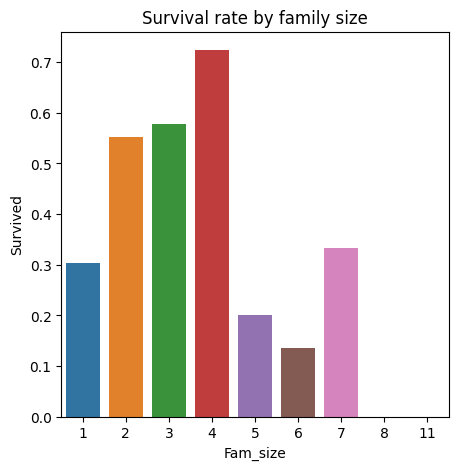

In [54]:

plt.figure(figsize=[5,5])
plt.title('Survival rate by family size')
g = sns.barplot(x='Fam_size', y='Survived', errorbar=None, data=train_df)




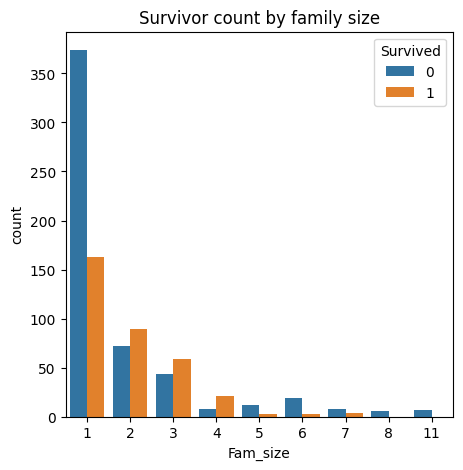

In [55]:
show_compare_countplot(train_df, "Fam_size", "Survived", "Survivor count by family size")

### 3.2 Feature Family Type:
    Creation of four groups that encodes the family size into 4 distinct groups.

In [56]:
train_df['Fam_type'] = pd.cut(train_df.Fam_size, [0,1,4,7,11], labels = ['Solo', 'Small', 'Big', 'Very big'])
test_df['Fam_type'] = pd.cut(test_df.Fam_size, [0,1,4,7,11], labels = ['Solo', 'Small', 'Big', 'Very big'])

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter,Fam_size,Fam_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2,A,2,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2,P,2,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mrs,ST,16,2,S,1,Solo
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1,1,2,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1,3,1,Solo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21,6,1,2,1,Solo
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Mrs,11,6,1,1,1,Solo
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mrs,W.,10,2,W,4,Small
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,11,6,1,1,1,Solo


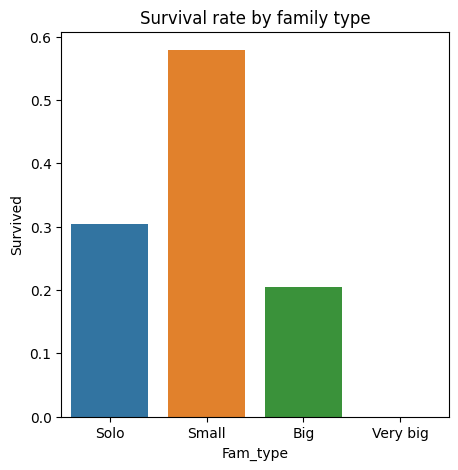

In [57]:

plt.figure(figsize=[5,5])
plt.title('Survival rate by family type')
g = sns.barplot(x='Fam_type', y = 'Survived', errorbar=None, data=train_df)

### 3. Training a Classifier
    Although we have a relatively large number of features available in relation to the size of the dataset, it does not necessarily make sense to use all of them (See discussion in section 2)

    We start by selecting the features we will use and isolating the target:

    ‘Pclass’, ‘Fare’, ‘Title’, ‘Embarked’, ‘Fam_type’, ‘Ticket_len’, ‘Ticket_2letter’
    Cabin will not be used and the relevant information about the feature age (which is being a young man) is already encoded in the title feature
    Sex will not be used to not confuse the classifier as adult males and young boys the same sex but are really different categories

In [58]:
train_df['Title'].unique()

array(['Mr', 'Mrs', 'Master', 'Rev', 'Dr'], dtype=object)

In [59]:
y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']
X = train_df[features]
X.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter
0,3,7.2500,Mr,S,Small,9,A/
1,1,71.2833,Mrs,C,Small,8,PC
2,3,7.9250,Mrs,S,Solo,16,ST
3,1,53.1000,Mrs,S,Small,6,11
4,3,8.0500,Mr,S,Solo,6,37


    The last step before fitting a model is to prepare a pipeline that will make sure that all the preprocessing performed on the training data is also done on the test data:

In [60]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']

In [61]:
# Inputing numerical values with median
numerical_transformer = SimpleImputer(strategy='median')

In [62]:
# Inputing missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [63]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Pclass', 'Title', 'Embarked', 'Fam_type',
                                  'Ticket_len', 'Ticket_2letter'])])

In [64]:
# Bundle preprocessing and modeling code
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

titanic_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Fam_type',
                                                   'Ticket_len',
                                                   'Ticket_2letter'])])),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=500,
                                        random_state=0))])

In [65]:
# Training
titanic_pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Fam_type',
                                                   'Ticket_len',
                                                   'Ticket_2letter'])])),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=500,
                                        random_state=0))])

In [66]:
print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.836


    We could also consolidate all the steps above into a single cell (ask chatGPT to explain those steps):

In [67]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']

# Inputing numerical values with median
numerical_transformer = SimpleImputer(strategy='median')

# Inputing missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Training
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.836


    Finally, we have our results:

In [68]:
X_test = test_df[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter
0,3,7.8292,Mr,Q,Solo,6,33
1,3,7.0000,Mrs,S,Small,6,36
2,2,9.6875,Mr,Q,Solo,6,24
3,3,8.6625,Mr,S,Solo,6,31
4,3,12.2875,Mrs,S,Small,7,31


In [69]:
predictions = titanic_pipeline.predict(X_test)
predictions

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

    Adding the 'Survived' column to all test_df alongisde the 'PassengerId' column:

In [70]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


    Check the test_df to see all the data and compare with the predicted results considering all the topics we exlored:

In [71]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter,Fam_size,Fam_type
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,33,6,6,3,1,Solo
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,36,6,6,3,2,Small
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,24,6,6,2,1,Solo
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,31,6,6,3,1,Solo
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,31,7,7,3,3,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr,A.,9,9,A,1,Solo
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Dona,PC,8,8,P,1,Solo
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,SO,18,18,S,1,Solo
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr,35,6,6,3,1,Solo


### 3. Further Improvements
    The pipeline presented here is only intended to be a starting point. Many possibilities for improvement have not even been addressed here. For example, more data imputation possibilities could be explored. Instead of the RF classifier, one could try the XGBoost classifier or, for example, combine several classifiers with the help of a voting classifier. The cabin feature also offers potential for improvement. Instead of simply extracting the first two letters, the number of cabins booked could be a possible feature, since there are passengers who have booked more than one cabin. We could think about ways to balance the dataset and try a different metric. You see, the possibilities are far from exploited.

### 4. Conclusion

    This exploration and analyze helps you to better understand the structured approach of a Machine Learning Engineer/Data Scientist. Exploratory data analysis is often time-consuming and requires asking the right questions. The added value of this analysis is that the number of weak features can be reduced and the remaining ones can be used to create meaningful features